In [3]:
import random
import varseek as vk
import os
import sys
import anndata as ad
import subprocess
import numpy as np
import pandas as pd

from varseek.utils import build_random_genome_read_df, fasta_to_fastq, create_mutant_t2g, fasta_to_fastq, find_genes_with_aligned_reads_for_kb_extract, calculate_metrics, create_stratified_metric_bar_plot, create_venn_diagram, get_header_set_from_fastq, plot_histogram, synthetic_data_summary_plot, plot_basic_bar_plot_from_dict, draw_confusion_matrix, check_for_read_kmer_in_mcrs, make_bus_df

In [4]:
out_dir_notebook="/home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_200mcrs_k59_nov16" #!!! change for each run
number_of_mutations_to_sample = 200
# Paths
mutation_metadata_df = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov16/mutation_metadata_df_updated_vk_info_exploded.csv"
mutation_index = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov16/mutation_reference.idx"
mutation_t2g = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_grch37_nov16/t2g_filtered.txt"



read_length = 150
strand = None  # None for strand-agnostic (randomly-selected), "f" for forward, "r" for reverse, "both" for both - make sure this matches the reference genome (vk build command) - strand = True -> "f" or "r" here; strand = False -> None or "both" here - note that the strand is randomly selected per *transcript*, such that all drawn reads will come from the same strand no matter what
add_noise=False
error_rate=0
max_errors=0
seq_id_column="seq_ID"
mut_column="mutation"
threads = 32
check_reason_for_read_fn = False

k = 59  # w=54 - even if I will use k=59 in my experiments, my synthetic data is designed so that w=(read_length-1), meaning that the mutation can be anywhere on the read from the first to the last nucleotide, and thus I cannot catch these edge mutations if k > (w+1) - if I want to run where k > w+1, then adjust w internal to vk sim accoringly
w = 54

sequences = "/home/jrich/data/varseek_data_fresh/reference/ensembl_grch37_release93/Homo_sapiens.GRCh37.cdna.all.fa"
reference_out_dir = "/home/jrich/data/varseek_data_fresh/reference"

In [5]:
out_dir_vk_build = f"{out_dir_notebook}/vk_build"

synthetic_reads_fastQ = f"{out_dir_notebook}/synthetic_reads.fq"
read_df_out = f"{out_dir_notebook}/synthetic_reads.csv"
mutation_metadata_df_out = f"{out_dir_notebook}/mutation_metadata_df_updated_vk_info_exploded_with_synthetic_read_info.csv"

kb_count_out = f"{out_dir_notebook}/kb_count_out"
kb_count_out_mm = f"{out_dir_notebook}/kb_count_out_mm"


seed=42
read_df = None
mutation_metadata_df_path = mutation_metadata_df
adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"

read_df_out_updated = read_df_out.replace(".csv", "_updated.csv")
unique_mcrs_df_out = f"{out_dir_notebook}/unique_mcrs_df.csv"

plot_output_folder = f"{out_dir_notebook}/plots"
os.makedirs(plot_output_folder, exist_ok=True)

In [4]:
# # run vk ref or notebook 1_1 (vk build, vk info with save_exploded_df=True, vk filter, kb ref)

# Simple synthetic reads - erase

In [ ]:
# #!!! TEMP
# import varseek
# mutation_metadata_df_path = mutation_metadata_df
# mutation_metadata_df = pd.read_csv(mutation_metadata_df_path)

# sim_data_df_path = "/home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp2/vk_build/sim_data_df.csv"
# sim_data_df = pd.read_csv(sim_data_df_path, usecols=["header", "mutant_sequence", "wt_sequence"])

# sim_data_df.rename(
#     columns={
#         "mutant_sequence": "mutant_sequence_read_parent",
#         "wt_sequence": "wt_sequence_read_parent",
#     },
#     inplace=True,
# )

# sim_data_df["mutant_sequence_read_parent_rc"] = sim_data_df["mutant_sequence_read_parent"].apply(varseek.varseek_build.reverse_complement)
# sim_data_df["mutant_sequence_read_parent_length"] = sim_data_df["mutant_sequence_read_parent"].str.len()

# sim_data_df["wt_sequence_read_parent_rc"] = sim_data_df["wt_sequence_read_parent"].apply(varseek.varseek_build.reverse_complement)
# sim_data_df["wt_sequence_read_parent_length"] = sim_data_df["wt_sequence_read_parent"].str.len()

# mutation_metadata_df = pd.merge(
#     mutation_metadata_df,
#     sim_data_df[
#         [
#             "header",
#             "mutant_sequence_read_parent",
#             "mutant_sequence_read_parent_rc",
#             "mutant_sequence_read_parent_length",
#             "wt_sequence_read_parent",
#             "wt_sequence_read_parent_rc",
#             "wt_sequence_read_parent_length",
#         ]
#     ],
#     on="header",
#     how="left",
#     suffixes=("", "_read_parent"),
# )

In [6]:
import sys
import importlib

# Remove the module from sys.modules
if 'varseek.sim' in sys.modules:
    del sys.modules['varseek.sim']

# Import the module and reload it
import varseek.varseek_sim
importlib.reload(varseek.varseek_sim)
import varseek as vk

# instead of using vk.sim() as before, I must explicitely use vk.varseek_sim.sim()

In [13]:
#!!! TEMP
sample_type = "all"
conditions = ['dlist-equal=none', 'mcrs_is_substring-isnottrue', 'pseudoaligned_to_human_reference_despite_not_truly_aligning-isnottrue']  # kmer_overlap_in_mcrs_reference-isnottrue


if not os.path.exists(mutation_metadata_df_out) or not os.path.exists(read_df_out):
    simulated_df_dict = vk.varseek_sim.sim(
        mutation_metadata_df = mutation_metadata_df,
        fastq_output_path = synthetic_reads_fastQ,
        sample_type=sample_type,
        number_of_mutations_to_sample=number_of_mutations_to_sample,
        strand=strand,
        number_of_reads_per_sample="all",  # not used when number_of_reads_per_sample_m and number_of_reads_per_sample_w are provided
        k=k,  # used in vk build with the respective index
        w=w,  # used in vk build with the respective index
        read_length=read_length,
        seed=seed,
        add_noise=add_noise,
        error_rate=error_rate,
        max_errors=max_errors,
        with_replacement=False,
        sequences=sequences,
        mutation_metadata_df_path=mutation_metadata_df_path,
        seq_id_column=seq_id_column,
        mut_column=mut_column,
        reference_out_dir=reference_out_dir,
        out_dir_vk_build=out_dir_vk_build,
        filters=conditions,
        read_df_out=read_df_out,
        mutation_metadata_df_out=mutation_metadata_df_out,
    )

    read_df, mutation_metadata_df = simulated_df_dict["read_df"], simulated_df_dict["mutation_metadata_df"]
else:
    read_df = pd.read_csv(read_df_out)
    mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

/tmp/ipykernel_146662/1891362556.py:36: DtypeWarning: Columns (11,12,13,26,27,31,53,68,70,81,82,86,88) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)


# Complex synthetic reads - uncomment

In [8]:
# number_of_mutations_to_sample = 100
# m_list = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512]
# w_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512]
# conditions = ['mutation_type-equal=substitution', 'mutation_type-notequal=substitution', 'dlist-equal=none', 'dlist-notequal=none', 'kmer_overlap_in_mcrs_reference-isfalse', 'kmer_overlap_in_mcrs_reference-istrue', 'is_near_splice_junction_10-isfalse', 'is_near_splice_junction_10-istrue']

# random.shuffle(m_list)
# random.shuffle(w_list)

# if not os.path.exists(mutation_metadata_df_out) and not os.path.exists(read_df_out):
#     for m in m_list:
#         for w in w_list:
#             for condition in conditions:
#                 read_fq_path_specific = synthetic_reads_fastQ.replace(".fq", f"_m{m}_w{w}_{condition.replace('=', '_')}.fq")
#                 condition_added_list = [condition, 'included_in_synthetic_reads-isnottrue']
                
#                 simulated_df_dict = vk.sim(
#                     mutation_metadata_df = mutation_metadata_df,
#                     fastq_output_path = read_fq_path_specific,
#                     fastq_parent_path = synthetic_reads_fastQ,
#                     read_df_parent=read_df,
#                     sample_type="all",
#                     number_of_mutations_to_sample=number_of_mutations_to_sample,
#                     strand=strand,
#                     number_of_reads_per_sample=None,  # not used when number_of_reads_per_sample_m and number_of_reads_per_sample_w are provided
#                     number_of_reads_per_sample_m=m,
#                     number_of_reads_per_sample_w=w,
#                     read_length=read_length,
#                     seed=seed,
#                     add_noise=add_noise,
#                     error_rate=error_rate,
#                     max_errors=max_errors,
#                     with_replacement=False,
#                     filters=condition_added_list,
#                     sequences=sequences,
#                     mutation_metadata_df_path=mutation_metadata_df_path,
#                     seq_id_column=seq_id_column,
#                     mut_column=mut_column,
#                     reference_out_dir=reference_out_dir,
#                     out_dir_vk_build=out_dir_vk_build,
#                 )

#                 mutation_metadata_df, read_df = simulated_df_dict['mutation_metadata_df'], simulated_df_dict['read_df']
# else:
#     read_df = pd.read_csv(read_df_out)
#     mutation_metadata_df = pd.read_csv(mutation_metadata_df_out)

# Random genome - uncomment

In [9]:
# # do kv sim with random genome
# mutation_metadata_df['start_position_for_which_read_contains_mutation_cdna'] = mutation_metadata_df['start_mutation_position_cdna'] - read_length + 1
# mutation_metadata_df['start_position_for_which_read_contains_mutation_genome'] = mutation_metadata_df['start_mutation_position_genome'] - read_length + 1

# number_of_random_reads_cdna = 10
# number_of_random_reads_genome = 10

# # read_df = build_random_genome_read_df(reference_fasta_file_path = reference_cdna_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, n = number_of_random_reads_cdna, read_length = read_length, input_type = "transcriptome", strand = None)
# # read_df = build_random_genome_read_df(reference_fasta_file_path = reference_genome_fasta, mutation_metadata_df = mutation_metadata_df, read_df = read_df, n = number_of_random_reads_genome, read_length = read_length, input_type = "genome", strand = None)

In [ ]:
# kb count
kb_count_command = ["kb", "count", "-t", str(threads), "--mm", "-k", str(k), "-i", mutation_index, "-g", mutation_t2g, "-x", "bulk", "--num", "--h5ad", "--parity", "single", "-o", kb_count_out_mm, synthetic_reads_fastQ]
if not os.path.exists(kb_count_out_mm) or len(os.listdir(kb_count_out_mm)) == 0:
    subprocess.run(kb_count_command, check=True)

kb_count_command.remove("--mm")
kb_count_command[kb_count_command.index(kb_count_out_mm)] = kb_count_out  # swap kb_count_out_mm for kb_count_out
if not os.path.exists(kb_count_out) or len(os.listdir(kb_count_out)) == 0:
    subprocess.run(kb_count_command, check=True)

In [8]:
import importlib
import varseek.utils.seq_utils
importlib.reload(varseek.utils.seq_utils)
from varseek.utils.seq_utils import make_bus_df

In [9]:
bus_df = make_bus_df(kallisto_out = kb_count_out_mm, fastq_file_list = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = False, union = False, assay = "bulk", bustools = "/home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")
bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

loading in transcripts
loading in barcodes
loading in fastq headers
loading in ec matrix
running bustools text


Read in 28289 BUS records


loading in bus df
merging ec df into bus df
loading in t2g df
saving bus df


In [10]:
import json
check_assertions = False
!cat {kb_count_out}/run_info.json | grep -E '"n_targets"|"n_processed"|"n_pseudoaligned"|"n_unique"|"p_pseudoaligned"|"p_unique"'

with open(f"{kb_count_out}/run_info.json", 'r') as f:
    data = json.load(f)

total_reads = data.get("n_processed", None)
n_pseudoaligned = data.get("n_pseudoaligned", None)
n_unique = data.get("n_unique", None)
n_multimapped = n_pseudoaligned - n_unique

if check_assertions:
    assert total_reads == n_pseudoaligned, "Total reads and pseudoaligned reads do not match"
    assert total_reads == n_unique, "Total reads and unique reads do not match"

219.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


	"n_targets": 5256981,
	"n_processed": 56616,
	"n_pseudoaligned": 28289,
	"n_unique": 28289,
	"p_pseudoaligned": 50.0,
	"p_unique": 50.0,


# Perspective of reads

TP: 28289, FP: 0, FN: 15, TN: 28312
Accuracy: 0.9997350572276388, Sensitivity: 0.9994700395703787, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │       28289        │         15         │
│ Actual Negative │         0          │       28312        │
└─────────────────┴────────────────────┴────────────────────┘

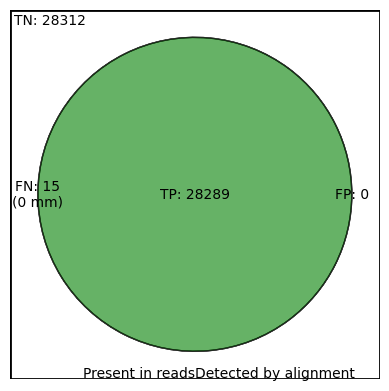

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:306: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()


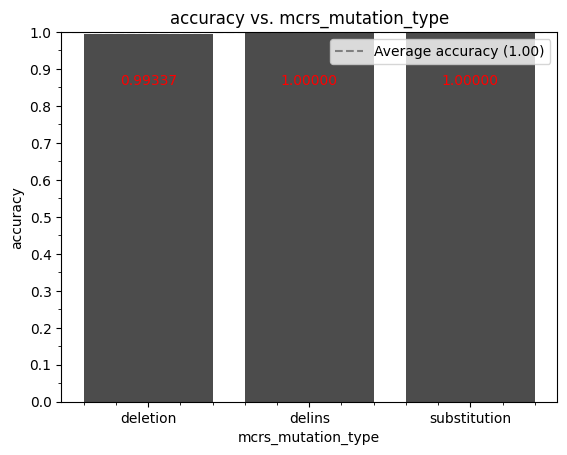

In [14]:
aligned_ids = set(bus_df['read_id'])
read_df['aligned_somewhere'] = read_df['read_id'].isin(aligned_ids)

read_df['TP_crude'] = (read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FP_crude'] = (~read_df['mutant_read'] & read_df['aligned_somewhere'])
read_df['FN_crude'] = (read_df['mutant_read'] & ~read_df['aligned_somewhere'])
read_df['TN_crude'] = (~read_df['mutant_read'] & ~read_df['aligned_somewhere'])

metric_dictionary_reads_crude = calculate_metrics(read_df, header_name = "read_header", check_assertions = check_assertions, crude = True, out = f"{plot_output_folder}/reads_metrics_crude.txt")
draw_confusion_matrix(metric_dictionary_reads_crude)

true_set_crude = set(read_df.loc[read_df['mutant_read'], 'read_header'])
positive_set_crude = set(read_df.loc[read_df['aligned_somewhere'], 'read_header'])
create_venn_diagram(true_set_crude, positive_set_crude, TN = metric_dictionary_reads_crude['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read_crude.png")

create_stratified_metric_bar_plot(read_df, 'mcrs_mutation_type', 'accuracy', overall_metric = metric_dictionary_reads_crude['accuracy'], log_x_axis = False, display_numbers = True, crude = True, out_path = f"{plot_output_folder}/accuracy_vs_mcrs_mutation_type_read_perspective_crude.png")

In [15]:
# Merge read_df with bus_df on 'read_id' and 'fastq_header' to bring in 'transcript_ids_list'
merged_df = read_df.merge(bus_df[['read_id', 'transcript_ids_list']], 
                          on='read_id', 
                          how='left')

# Create 'multimapped' column as True if length of 'transcript_ids_list' > 1, else False
read_df['multimapped'] = merged_df['transcript_ids_list'].apply(lambda x: len(x) > 1 if isinstance(x, list) else False)


read_df = read_df.merge(bus_df[['read_id', 'transcript_names_final']], 
                        on='read_id', 
                        how='left').rename(columns={'transcript_names_final': 'mcrs_id_to_which_the_read_aligned'})

# Convert lists to comma-separated strings, keeping NaN values as NaN
read_df['mcrs_id_to_which_the_read_aligned'] = read_df['mcrs_id_to_which_the_read_aligned'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else x
)

TP: 28289, FP: 0, FN: 15, TN: 28312
Accuracy: 0.9997350572276388, Sensitivity: 0.9994700395703787, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │       28289        │         15         │
│ Actual Negative │         0          │       28312        │
└─────────────────┴────────────────────┴────────────────────┘

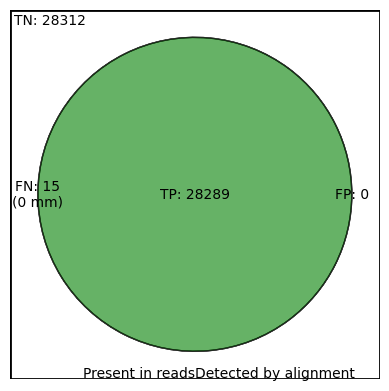

In [16]:
read_df['aligned_to_correct_mcrs'] = (read_df['mcrs_id'] == read_df['mcrs_id_to_which_the_read_aligned'])

# Check if 'mcrs_id' is a substring of any item in 'mcrs_id_to_which_the_read_aligned'
read_df['aligned_to_correct_mcrs_including_multimapped'] = read_df.apply(
    lambda row: row['mcrs_id'] in row['mcrs_id_to_which_the_read_aligned'] 
                if isinstance(row['mcrs_id_to_which_the_read_aligned'], str) else False,
    axis=1
)

read_df['TP'] = (read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FP'] = (~read_df['mutant_read'] & read_df['aligned_to_correct_mcrs'])
read_df['FN'] = (read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])
read_df['TN'] = (~read_df['mutant_read'] & ~read_df['aligned_to_correct_mcrs'])

metric_dictionary_reads = calculate_metrics(read_df, header_name = "read_header", check_assertions = check_assertions, out = f"{plot_output_folder}/read_metrics.txt")
draw_confusion_matrix(metric_dictionary_reads)

true_set = set(read_df.loc[read_df['mutant_read'], 'read_header'])
positive_set = set(read_df.loc[read_df['aligned_to_correct_mcrs'], 'read_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reads['TN'], mm = n_multimapped, out_path = f"{plot_output_folder}/venn_diagram_read.png")

In [17]:
read_df['reason_for_fn'] = np.nan

if check_reason_for_read_fn:
    # Loop through each row in read_df where 'FN' is True
    for index, row in read_df.loc[read_df['FN']].iterrows():
        reason_for_fn_sublist = []

        # Get the mcrs_id from the current row in read_df
        mcrs_id = row['mcrs_id']
        
        # Find the corresponding mcrs_sequence_length in mutation_metadata_df
        matching_length = mutation_metadata_df.loc[
            mutation_metadata_df['mcrs_id'] == mcrs_id, 'mcrs_sequence_length'
        ]
        
        # Check if there's a match and if the length is less than 55
        if not matching_length.empty and matching_length.iloc[0] < (2*k-1):
            reason_for_fn_sublist.append("short_mcrs_id")

        if row['multimapped']:
            reason_for_fn_sublist.append("multimapped")
        
        dlist_status = mutation_metadata_df.loc[
            mutation_metadata_df['mcrs_id'] == mcrs_id, 'dlist'
        ]

        if not dlist_status.empty and dlist_status.iloc[0] != "none":
            reason_for_fn_sublist.append("dlisted")

        if reason_for_fn_sublist:
            read_df.at[index, 'reason_for_fn'] = reason_for_fn_sublist  # might be cast as a string if length == 1 (especially for first row), but this doesn't really matter for me

    num_nan_reasons = read_df.loc[read_df['FN'], 'reason_for_fn'].isna().sum()

    print(f"Number of FN reads with no reasons: {num_nan_reasons}")

    # mcrs_set = set(unique_mcrs_df.loc[unique_mcrs_df['FN'] == True, 'mcrs_header'])
    # filtered_read_df = read_df[(read_df['FN']) & (~read_df['reference_header'].isin(mcrs_set))]

In [18]:
# Get the unique mcrs_id values from read_df where FN is True
matching_mcrs_ids = read_df.loc[read_df['FN'], 'mcrs_id'].unique()

# Filter mutation_metadata_df for rows with matching mcrs_id values and access mcrs_sequence_length
matching_mcrs_sequence_lengths = mutation_metadata_df.loc[
    mutation_metadata_df['mcrs_id'].isin(matching_mcrs_ids), 'mcrs_sequence_length'
]

# Perspective of reference

In [19]:
columns_to_list = ["header","order","seq_ID","mutation","mutation_type","wt_sequence","nucleotide_positions","actual_mutation","mutation_cds","mutation_aa","GENOMIC_MUTATION_ID","chromosome","strand","mutation_genome","gene_name","mutation_id","start_mutation_position","end_mutation_position","nucleotide_positions_cdna","actual_mutation_cdna","start_mutation_position_cdna","end_mutation_position_cdna","header_genome","header_cdna","header_cds","nucleotide_positions_genome","actual_mutation_genome","start_mutation_position_genome","end_mutation_position_genome","distance_to_nearest_splice_junction","is_near_splice_junction_10","nearby_mutations","nearby_mutations_count","has_a_nearby_mutation"]
columns_to_or = ["included_in_synthetic_reads_mutant","included_in_synthetic_reads_wt","included_in_synthetic_reads", "any_noisy_reads", "any_noisy_reads_mutant", "any_noisy_reads_wt"]
columns_to_sum = ["list_of_read_starting_indices_mutant","list_of_read_starting_indices_wt","number_of_reads_wt","number_of_reads_mutant","noisy_read_indices_mutant","noisy_read_indices_wt"]
columns_to_all = []

# #!!!TEMP
# drop all columns in columns_to_list
columns_to_list.remove("order")
columns_to_list.remove("distance_to_nearest_splice_junction")
mutation_metadata_df.drop(columns=columns_to_list, inplace=True)
# #!!!TEMP

mutation_metadata_df_original_column_order = mutation_metadata_df.columns
columns_to_list = [col for col in columns_to_list if col in mutation_metadata_df_original_column_order]
columns_to_or = [col for col in columns_to_or if col in mutation_metadata_df_original_column_order]
columns_to_sum = [col for col in columns_to_sum if col in mutation_metadata_df_original_column_order]

for column in list(columns_to_list):
    mutation_metadata_df[column] = mutation_metadata_df[column].apply(
        lambda x: tuple(x) if isinstance(x, list) else x
    )

unique_mcrs_df = (
    mutation_metadata_df.sort_values('order').groupby('mcrs_header', as_index=False)
    .agg(
        {**{col: list for col in list(columns_to_list)},  # list these values
        **{col: sum for col in list(columns_to_sum)},  # Take the first value for these columns
        **{col: np.any for col in list(columns_to_or)},  # OR these values
        **{col: np.all for col in list(columns_to_all)},  # AND these values
        **{col: 'first' for col in mutation_metadata_df.columns if col not in columns_to_list + columns_to_or + columns_to_all + columns_to_sum + ['mcrs_header']}}  # Take the first value for other columns
    ).reset_index(drop=True)
)

unique_mcrs_df = unique_mcrs_df[mutation_metadata_df_original_column_order]

unique_mcrs_df['tumor_purity'] = unique_mcrs_df['number_of_reads_mutant'] / unique_mcrs_df['number_of_reads_wt']

unique_mcrs_df['tumor_purity'] = np.where(
    np.isnan(unique_mcrs_df['tumor_purity']), 
    np.nan,  # Keep NaN as NaN
    unique_mcrs_df['tumor_purity']  # Keep the result for valid divisions
)

try:
    unique_mcrs_df['min_distance_to_splice_junction'] = unique_mcrs_df['distance_to_nearest_splice_junction'].apply(
        lambda x: min(x) if isinstance(x, list) and len(x) > 0 else np.nan
    )
except Exception as e:
    pass

In [20]:
# TODO (very low priority): once I run more complex tests to verify that bus df and adata agree, then I can load in these values from bus df and remove the need to run kb count without mm

adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
adata = ad.read_h5ad(adata_path)

# Find the indices of non-zero values in adata.X
non_zero_indices = np.nonzero(adata.X)

# Get the non-zero values
non_zero_values = np.squeeze(np.asarray(adata.X[non_zero_indices])).astype(int)

# Get the corresponding gene names
mcrs_ids = adata.var.index[non_zero_indices[1]].to_numpy().flatten()

mcrs_ids = mcrs_ids.astype(str)

# Create a DataFrame
adata_df = pd.DataFrame({
    'mcrs_id': mcrs_ids,
    'number_of_reads_aligned_to_this_item': non_zero_values
})

unique_mcrs_df = unique_mcrs_df.merge(adata_df, on='mcrs_id', how='left')
unique_mcrs_df['received_an_aligned_read'] = ~pd.isna(unique_mcrs_df['number_of_reads_aligned_to_this_item'])

# # set to int - will need to do Int64 to work
# unique_mcrs_df['number_of_reads_mutant'] = unique_mcrs_df['number_of_reads_mutant'].astype(int)
# unique_mcrs_df['number_of_reads_wt'] = unique_mcrs_df['number_of_reads_wt'].astype(int)
# unique_mcrs_df['number_of_reads_aligned_to_this_item'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'].astype(int)

## Temporary detour: make sure bus_df and adata agree

In [21]:
bus_df_subset = bus_df[["transcript_names_final", "counted_in_count_matrix", "count"]]

bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(
    lambda x: x[0] if isinstance(x, list) and x else x
)

# Group by the string representation
bus_df_subset_grouped = bus_df_subset.groupby('transcript_names_final', as_index=False).agg({
    'counted_in_count_matrix': 'first',
    'count': 'sum'
})

# Set values in 'count' to 0 where 'counted_in_count_matrix' is False
bus_df_subset_grouped.loc[bus_df_subset_grouped['counted_in_count_matrix'] == False, 'count'] = 0

bus_df_subset_grouped.rename(columns={"transcript_names_final": "mcrs_id", "count": "count_bus"}, inplace=True)

bus_df_subset_grouped = bus_df_subset_grouped.merge(adata_df, on='mcrs_id', how='left')
bus_df_subset_grouped = bus_df_subset_grouped.rename(columns={'number_of_reads_aligned_to_this_item': 'count_adata'})


mismatch_count = (bus_df_subset_grouped['count_bus'] != bus_df_subset_grouped['count_adata']).sum()
print(f"Number of mismatches between BUS file and adata: {mismatch_count}")

Number of mismatches between BUS file and adata: 0


/tmp/ipykernel_146662/2528789349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_df_subset['transcript_names_final'] = bus_df_subset['transcript_names_final'].apply(


TP: 200, FP: 0, FN: 0, TN: 5299821
Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │        200         │         0          │
│ Actual Negative │         0          │      5299821       │
└─────────────────┴────────────────────┴────────────────────┘

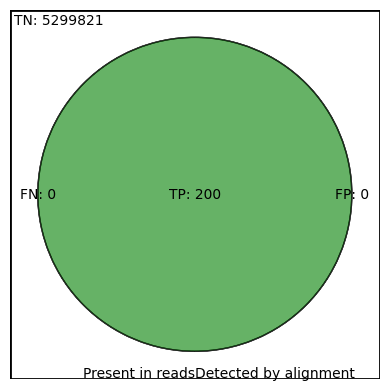

In [22]:
unique_mcrs_df['TP_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FP_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['FN_crude'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])
unique_mcrs_df['TN_crude'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = check_assertions, crude = True, out = f"{plot_output_folder}/reference_metrics_crude.txt")
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference_crude.png")

In [23]:
aligned_read_df_mutant = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['mutant_read'] == True)]
mcrs_counts_mutant = aligned_read_df_mutant.groupby('mcrs_id').size().reset_index(name='number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_mutant, on='mcrs_id', how='left')
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

unique_mcrs_df['mutation_expression_prediction_error'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_mutant']  # positive means overpredicted, negative means underpredicted




aligned_read_df_wt = read_df.loc[(read_df['aligned_somewhere'] == True) & (read_df['wt_read'] == True)]
mcrs_counts_wt = aligned_read_df_wt.groupby('mcrs_id').size().reset_index(name='number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere')

unique_mcrs_df = unique_mcrs_df.merge(mcrs_counts_wt, on='mcrs_id', how='left')
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].fillna(0).astype(int)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_didnt_align_anywhere'] = unique_mcrs_df['number_of_reads_wt'] - unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere']

In [24]:
# Step 1: Group by 'mcrs_header' and count 'aligned_to_correct_mcrs' (sum will count True as 1, False as 0)
aligned_counts = read_df.groupby('mcrs_header')['aligned_to_correct_mcrs'].sum().reset_index()

# Rename the column to something meaningful, like 'correct_alignment_count'
aligned_counts.rename(columns={'aligned_to_correct_mcrs': 'number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'}, inplace=True)

# Step 2: Merge the counts with unique_mcrs_df on the 'mcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, aligned_counts, on='mcrs_header', how='left')

# Fill NaN values with 0 in case some mcrs_header values in unique_mcrs_df do not appear in read_df
unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'].fillna(0, inplace=True)

unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'] = unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly'] > 0

In [25]:
# Step 1: Group by 'mcrs_header_to_which_the_read_aligned' and collect 'read_header' into lists
reads_mapped = read_df.groupby('mcrs_id_to_which_the_read_aligned')['read_header'].apply(list).reset_index()

# Rename the column to 'reads_mapped_to_this_reference_item' for clarity
reads_mapped.rename(columns={'read_header': 'reads_mapped_to_this_reference_item'}, inplace=True)

# Step 2: Merge the list of read headers with unique_mcrs_df on the 'mcrs_header' column
unique_mcrs_df = pd.merge(unique_mcrs_df, reads_mapped, left_on='mcrs_id', right_on='mcrs_id_to_which_the_read_aligned', how='left')
unique_mcrs_df.drop(columns='mcrs_id_to_which_the_read_aligned', inplace=True)

# Fill NaN values with empty lists in case there are no matching read headers for some mcrs_header values
unique_mcrs_df['reads_mapped_to_this_reference_item'] = unique_mcrs_df['reads_mapped_to_this_reference_item'].apply(lambda x: x if isinstance(x, list) else [])

unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_MUTANT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)
unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'] = unique_mcrs_df['number_of_WT_reads_belonging_to_the_mcrs_item_that_aligned_somewhere'].astype(bool)

TP: 200, FP: 0, FN: 0, TN: 5299821
Accuracy: 1.0, Sensitivity: 1.0, Specificity: 1.0


                      Confusion Matrix                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Positive ┃ Predicted Negative ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Actual Positive │        200         │         0          │
│ Actual Negative │         0          │      5299821       │
└─────────────────┴────────────────────┴────────────────────┘

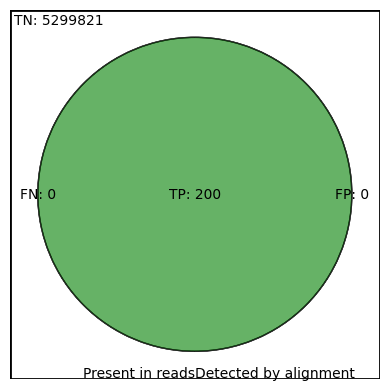

/home/jrich/miniconda3/envs/varseek2/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7037: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)
/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:531: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].abs()


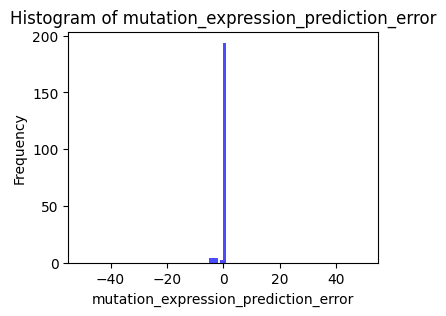

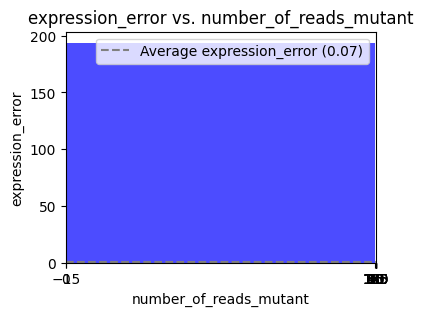

/home/jrich/Desktop/varseek/varseek/utils/visualization_utils.py:306: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = df.groupby(group_col).sum()


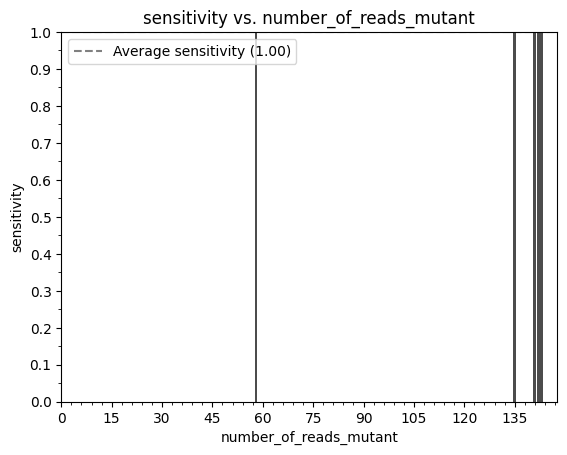

In [26]:
unique_mcrs_df['TP'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FP'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['FN'] = (unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])
unique_mcrs_df['TN'] = (~unique_mcrs_df['included_in_synthetic_reads_mutant'] & ~unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'])

metric_dictionary_reference = calculate_metrics(unique_mcrs_df, header_name = "mcrs_header", check_assertions = check_assertions, out = f"{plot_output_folder}/reference_metrics.txt")
draw_confusion_matrix(metric_dictionary_reference)

true_set = set(unique_mcrs_df.loc[unique_mcrs_df['included_in_synthetic_reads_mutant'], 'mcrs_header'])
positive_set = set(unique_mcrs_df.loc[unique_mcrs_df['received_an_aligned_read_from_one_of_its_corresponding_reads'], 'mcrs_header'])
create_venn_diagram(true_set, positive_set, TN = metric_dictionary_reference['TN'], out_path = f"{plot_output_folder}/venn_diagram_reference.png")

unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_did_not_align_correctly'] = unique_mcrs_df['number_of_reads_mutant'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']
unique_mcrs_df['number_of_reads_aligned_to_this_mcrs_item_that_aligned_incorrectly'] = unique_mcrs_df['number_of_reads_aligned_to_this_item'] - unique_mcrs_df['number_of_reads_belonging_to_this_mcrs_item_that_mapped_here_correctly']

plot_histogram(unique_mcrs_df.loc[~unique_mcrs_df['TN']], 'mutation_expression_prediction_error', log_scale = False, out_path = f"{plot_output_folder}/histogram_mutation_expression_prediction_error_linear_axis.png")
plot_histogram(unique_mcrs_df.loc[~unique_mcrs_df['TN']], 'mutation_expression_prediction_error', log_scale = True, out_path = f"{plot_output_folder}/histogram_mutation_expression_prediction_error_log_axis.png")

metric_dictionary_reference['mutation_expression_prediction_error_abs_mean'] = unique_mcrs_df.loc[~unique_mcrs_df['TN'], 'mutation_expression_prediction_error'].abs().mean()
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'expression_error', overall_metric = metric_dictionary_reference['mutation_expression_prediction_error_abs_mean'], log_x_axis = False, out_path = f"{plot_output_folder}/expression_error_vs_number_of_reads_mutant.png")
# create_stratified_metric_bar_plot(unique_mcrs_df, 'min_distance_to_splice_junction', 'accuracy', overall_metric = metric_dictionary_reference['accuracy'], log_x_axis = False, bins = [-1, 0, 1, 5, 10, 50, 100, float('inf')])
create_stratified_metric_bar_plot(unique_mcrs_df, 'number_of_reads_mutant', 'sensitivity', overall_metric = metric_dictionary_reference['sensitivity'], log_x_axis = False, out_path = f"{plot_output_folder}/accuracy_vs_number_of_reads_mutant.png")
#* add more here
#*** create similar plots for y in {sensitivity, specificity}, and x in {number_of_reads_wt, tumor_purity} and determine cutoffs for which varseek is reliable

In [27]:
unexplainable_references = 0
for header in metric_dictionary_reference['FNs']:
    print(f"Header {header}")
    did_not_align_anywhere = (read_df[read_df['mcrs_header'] == header])['FN_crude'].all()
    print(f"All did not align anywhere for {header}: {did_not_align_anywhere}")
    did_not_align_to_correct_position = (read_df[read_df['mcrs_header'] == header])['FN'].all()
    print(f"All did not align to correct mcrs for {header}: {did_not_align_to_correct_position}")
    multimapped = (read_df[read_df['mcrs_header'] == header])['multimapped'].all()
    print(f"All multimapped for {header}: {multimapped}")
    if not did_not_align_anywhere and not did_not_align_to_correct_position and not multimapped:
        unexplainable_references += 1

if unexplainable_references > 0:
    print(f"Unexplainable references: {unexplainable_references}")
else:
    print("All explainable!")

All explainable!


In [28]:
unique_mcrs_df.to_csv(unique_mcrs_df_out, index=False)
read_df.to_csv(read_df_out_updated, index=False)

In [29]:
# read_df = pd.read_csv(read_df_out_updated)
# unique_mcrs_df = pd.read_csv(unique_mcrs_df_out)

In [30]:
print(read_df.columns)
print(unique_mcrs_df.columns)
print(mutation_metadata_df.columns)

Index(['read_id', 'read_header', 'read_sequence', 'read_index', 'read_strand',
       'reference_header', 'mcrs_id', 'mcrs_header', 'mcrs_mutation_type',
       'mutant_read', 'wt_read', 'region_included_in_mcrs_reference',
       'noise_added', 'aligned_somewhere', 'TP_crude', 'FP_crude', 'FN_crude',
       'TN_crude', 'multimapped', 'mcrs_id_to_which_the_read_aligned',
       'aligned_to_correct_mcrs',
       'aligned_to_correct_mcrs_including_multimapped', 'TP', 'FP', 'FN', 'TN',
       'reason_for_fn'],
      dtype='object')
Index(['mcrs_header', 'order', 'distance_to_nearest_splice_junction',
       'mcrs_sequence', 'mutant_sequence_rc', 'mcrs_id', 'header_list',
       'order_list', 'mcrs_source', 'header_with_gene_name',
       'number_of_mutations_in_this_gene_total', 'mcrs_header_length',
       'mcrs_sequence_length', 'dlist', 'dlist_substring',
       'number_of_alignments_to_normal_human_reference_cdna',
       'number_of_alignments_to_normal_human_reference_genome',
      

In [31]:
# eg /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp/plots/read_metrics.txt or /home/jrich/data/varseek_data_fresh/vk_sim_2024nov24_temp/plots/reference_metrics.txt
# no_noise_read_metrics = ""
# substitution_noise_read_metrics = ""
# deletion_noise_read_metrics = ""
# insertion_noise_read_metrics = ""
# all_noise_read_metrics = ""
# metric = "accuracy"

# from varseek.utils import retrieve_value_from_metric_file

# accuracy_dict = {}
# accuracy_dict['No Noise'] = retrieve_value_from_metric_file(metric, no_noise_read_metrics)
# accuracy_dict['Substitution Noise'] = retrieve_value_from_metric_file(metric, substitution_noise_read_metrics)
# accuracy_dict['Deletion Noise'] = retrieve_value_from_metric_file(metric, deletion_noise_read_metrics)
# accuracy_dict['Insertion Noise'] = retrieve_value_from_metric_file(metric, insertion_noise_read_metrics)
# accuracy_dict['All Noise'] = retrieve_value_from_metric_file(metric, all_noise_read_metrics)

# from matplotlib import pyplot as plt

# plot_basic_bar_plot_from_dict(accuracy_dict, y_axis=metric)

## Validating with kb extract

In [32]:
# kb_extract_out_all_slow = f"{out_dir_notebook}/kb_extract_out_all_slow"
# df_extract_combined = pd.DataFrame(columns=['read_id', 'mcrs_id_to_which_the_read_aligned_kb_extract'])

# if strand is None or strand == "both":
#     strand_kb_extract = "unstranded"
# elif strand == "f":
#     strand_kb_extract = "forward"
# elif strand == "r":
#     strand_kb_extract = "reverse"

# # # running with --extract_all will make all ~5.3M reference items as the targets, which is much longer than manually defining the list of mutations as my targets - but I would imagine the outcome is the same; also, extract_all will output all files at once rather than one at a time (not good if I want to check progress throughout or break up for multithreading, but it can avoid the issue where mcrs_string_with_aligned_reads is too many characters)
# # kb_extract_command = f"kb extract --strand {strand_kb_extract} --verbose -k {k} -t {threads} --extract_all -o {kb_extract_out_all_slow} -i {mutation_index} -g {mutation_t2g} {synthetic_reads_fastQ}"
# adata_path = f"{kb_count_out}/counts_unfiltered/adata.h5ad"
# mapped_mutations_string = find_genes_with_aligned_reads_for_kb_extract(adata_path)
# mcrs_set_with_aligned_reads = set(mapped_mutations_string.split())
# mcrs_string_with_aligned_reads = ' '.join(f"'{x}'" for x in mcrs_set_with_aligned_reads)
# kb_extract_command = f"kb extract --verbose -k {k} --mm -t {threads} --targets {mcrs_string_with_aligned_reads} -o {kb_extract_out_all_slow} -i {mutation_index} -g {mutation_t2g} {synthetic_reads_fastQ}"

# print(kb_extract_command)

run the command in tmux!

In [33]:
# if 'bus_df' not in globals():
#     from varseek.utils import make_bus_df
#     bus_df = make_bus_df(kallisto_out = kb_count_out_mm, fastq_file = synthetic_reads_fastQ, t2g_file = mutation_t2g, mm = True, union = False, assay = "bulk", bustools = "/home/jrich/miniconda3/envs/varseek/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")
#     bus_df.rename(columns={"fastq_header": "read_id"}, inplace=True)

# # add some code here to check where these map
# for subdir in os.listdir(kb_extract_out_all_slow):
#     subdir_path = os.path.join(kb_extract_out_all_slow, subdir)
#     if os.path.isdir(subdir_path):
#         fastq_file = os.path.join(subdir_path, '1.fastq.gz')
#         if os.path.exists(fastq_file):
#             # Run get_header_set_from_fastq for the fastq file
#             aligned_reads_kb_extract = get_header_set_from_fastq(fastq_file)
#             df_temp = pd.DataFrame(aligned_reads_kb_extract, columns=['read_id'])
#             df_temp['mcrs_id_to_which_the_read_aligned_kb_extract'] = subdir  # Add subdirectory info
#             df_extract_combined = pd.concat([df_extract_combined, df_temp], ignore_index=True)  # Concatenate the new DataFrame with df_extract_combined

# df_extract_combined = df_extract_combined.groupby('read_id')['mcrs_id_to_which_the_read_aligned_kb_extract'].apply(list).reset_index()

# df_extract_combined = df_extract_combined.merge(bus_df[["read_id", "gene_names_final"]], on='read_id', how='left')
# df_extract_combined.rename(columns={"gene_names_final": "mcrs_id_to_which_the_read_aligned_bus_df"}, inplace=True)
# mismatch_count_kb_extract = (df_extract_combined['mcrs_id_to_which_the_read_aligned_bus_df'] != df_extract_combined['mcrs_id_to_which_the_read_aligned_kb_extract']).sum()
# print(f"Number of mismatches between BUS file and kb extract: {mismatch_count_kb_extract}")

In [ ]:
import sys
import tracemalloc

from collections import OrderedDict
from varseek.utils import read_fasta

def memory_tracker(func, *args, object_name = "Object", **kwargs):
    tracemalloc.start()
    
    # Run the function
    result = func(*args, **kwargs)
    
    # Get memory usage
    current, peak = tracemalloc.get_traced_memory()
    
    # Stop tracemalloc
    tracemalloc.stop()
    
    # Print memory usage
    print(f"Size of {object_name}: {sys.getsizeof(result)/1024/1024:.3f} MB")
    print(f"Current memory usage from {object_name}: {current / 1024 / 1024:.3f} MB")
    print(f"Peak memory usage from {object_name}: {peak / 1024 / 1024:.3f} MB")
    
    return result

def lookup_keys(data, start, end):
    # Create keys to lookup
    keys = [f"vcrs_{i:07d}" for i in range(start, end + 1)]
    for key in keys:
        _ = data[key]  # Access the key

def time_tracker(func, *args, object_name = "Object", **kwargs):
    import time
    
    # Start timing
    start = time.time()
    
    # Run the function
    result = func(*args, **kwargs)

    # End timing
    end = time.time()

    # Print time taken
    print(f"Time taken by {object_name}: {end - start:.6f} seconds")

def create_header_to_sequence_ordered_dict_from_fasta_WITHOUT_semicolon_splitting(input_fasta):
    mutant_reference = OrderedDict()
    for mutant_reference_header, mutant_reference_sequence in read_fasta(input_fasta):
        mutant_reference[mutant_reference_header] = mutant_reference_sequence
    return mutant_reference

def make_microdict_object(input_fasta):
    from microdict import mdict
    mutant_reference = mdict.create("str:str")
    for mutant_reference_header, mutant_reference_sequence in read_fasta(input_fasta):
        mutant_reference[mutant_reference_header] = mutant_reference_sequence
    return mutant_reference

def make_pyfastx_object(input_fasta):
    import pyfastx
    return pyfastx.Fasta(input_fasta, build_index=True)

In [ ]:
input_fasta = "/home/jrich/data/varseek_data_fresh/vk_build_pipeline_t2t_nov16/mcrs.fa"
dict_object = memory_tracker(create_header_to_sequence_ordered_dict_from_fasta_WITHOUT_semicolon_splitting, input_fasta, object_name = "dict")
pyfastx_object = memory_tracker(make_pyfastx_object, input_fasta, object_name = "pyfastx")
microdict_object = memory_tracker(make_microdict_object, input_fasta, object_name = "microdict")

time_tracker(lookup_keys, dict_object, 1, 300000, object_name = "dict")
time_tracker(lookup_keys, pyfastx_object, 1, 300000, object_name = "pyfastx")
time_tracker(lookup_keys, microdict_object, 1, 300000, object_name = "microdict")

Size of dict: 385.744 MB
Current memory usage from dict: 1491.976 MB
Peak memory usage from dict: 1491.989 MB
Size of pyfastx: 0.000 MB
Current memory usage from pyfastx: 0.000 MB
Peak memory usage from pyfastx: 0.000 MB
Time taken by dict: 0.188558 seconds
Time taken by pyfastx: 3.505597 seconds


In [88]:
import sqlite3

class SQLiteDict:
    def __init__(self, db_path: str, table_name: str = "kv_store"):
        self.db_path = db_path
        self.table_name = table_name
        self.conn = sqlite3.connect(self.db_path)
        self._initialize_table()

    def _initialize_table(self):
        """Create the table if it doesn't exist."""
        with self.conn:
            self.conn.execute(f"""
                CREATE TABLE IF NOT EXISTS {self.table_name} (
                    key TEXT PRIMARY KEY,
                    value TEXT
                )
            """)

    def __setitem__(self, key, value):
        """Set a key-value pair."""
        with self.conn:
            self.conn.execute(
                f"INSERT OR REPLACE INTO {self.table_name} (key, value) VALUES (?, ?)",
                (key, value)
            )

    def __getitem__(self, key):
        """Get a value by key."""
        cursor = self.conn.execute(
            f"SELECT value FROM {self.table_name} WHERE key = ?",
            (key,)
        )
        result = cursor.fetchone()
        if result is None:
            raise KeyError(f"Key '{key}' not found.")
        return result[0]

    def __delitem__(self, key):
        """Delete a key-value pair."""
        with self.conn:
            cursor = self.conn.execute(
                f"DELETE FROM {self.table_name} WHERE key = ?",
                (key,)
            )
            if cursor.rowcount == 0:
                raise KeyError(f"Key '{key}' not found.")

    def __contains__(self, key):
        """Check if a key exists."""
        cursor = self.conn.execute(
            f"SELECT 1 FROM {self.table_name} WHERE key = ?",
            (key,)
        )
        return cursor.fetchone() is not None

    def keys(self):
        """Return all keys."""
        cursor = self.conn.execute(f"SELECT key FROM {self.table_name}")
        return [row[0] for row in cursor.fetchall()]

    def values(self):
        """Return all values."""
        cursor = self.conn.execute(f"SELECT value FROM {self.table_name}")
        return [row[0] for row in cursor.fetchall()]

    def items(self):
        """Return all key-value pairs."""
        cursor = self.conn.execute(f"SELECT key, value FROM {self.table_name}")
        return cursor.fetchall()

    def __iter__(self):
        """Iterate over keys."""
        return iter(self.keys())

    def __len__(self):
        """Return the number of items."""
        cursor = self.conn.execute(f"SELECT COUNT(*) FROM {self.table_name}")
        return cursor.fetchone()[0]

    def clear(self):
        """Remove all key-value pairs."""
        with self.conn:
            self.conn.execute(f"DELETE FROM {self.table_name}")

    def close(self):
        """Close the database connection."""
        self.conn.close()

# Example Usage
db_dict = SQLiteDict("example.db")

db_dict["foo"] = "bar"
print(db_dict["foo"])  # Output: bar

db_dict["baz"] = "qux"
print("foo" in db_dict)  # Output: True
print(db_dict.keys())  # Output: ['foo', 'baz']

del db_dict["foo"]
print(len(db_dict))  # Output: 1

db_dict.clear()
db_dict.close()


bar
True
['baz', 'foo']
1


In [89]:
db_dict